In [1]:
import os 
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import time

In [2]:
ABS_PATH_TRAIN = 'NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training'
ABS_PATH_VAL = 'NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing'

#### use same data as the one that gave the best results in terms of model + same sort of experiments

# Actual training

In [11]:
classifier = RandomForestClassifier(n_estimators=200,
                                       max_depth=30,
                                       n_jobs=6,
                                   random_state=0,
                                   class_weight='balanced')

In [12]:
train_files = os.listdir(ABS_PATH_TRAIN)
val_files = os.listdir(ABS_PATH_VAL)

In [13]:
number_labels = 5
per_day_performance_train = {}
per_day_performance_val= {}
importances_d = {}
levels = [1, 2, 3, 5, 10]
for day, file in enumerate(zip(train_files,val_files)):
        train_file, val_file = file
        train_results = []
        val_results = []
        importances = []
        for k in range(number_labels):
            train_data = np.loadtxt(os.path.join(ABS_PATH_TRAIN, train_file)).T
            train_X, train_y = train_data[:, :144], train_data[:, 144+k]

            val_data = np.loadtxt(os.path.join(ABS_PATH_VAL, val_file)).T
            val_X, val_y = val_data[:, :144], val_data[:, 144+k]
            
            classifier.fit(train_X, train_y)
            
            prediction = classifier.predict(val_X)
            
            f1_score_val = f1_score(y_pred=prediction, y_true=val_y, average='macro')
            f1_score_train = f1_score(y_pred=classifier.predict(train_X), y_true=train_y, average='macro')
            
            train_results.append(f1_score_train)
            val_results.append(f1_score_val)
            importances.append(classifier.feature_importances_)
            
            print(f'Train f1 score for {day+1} days and level {levels[k]} is {f1_score_train}')
            print(f'Vlidation f1 score for {day+1} days and level {levels[k]} is {f1_score_val}')
            print('*'*30)
            
        per_day_performance_train[day] = train_results
        per_day_performance_val[day] = val_results
        importances_d[day] = importances
        
            

Train f1 score for 1 days and level 1 is 0.9972222735776196
Vlidation f1 score for 1 days and level 1 is 0.4556038805468159
******************************
Train f1 score for 1 days and level 2 is 0.9910284418844834
Vlidation f1 score for 1 days and level 2 is 0.2259651973840676
******************************
Train f1 score for 1 days and level 3 is 0.9947433972873253
Vlidation f1 score for 1 days and level 3 is 0.2385151053416412
******************************
Train f1 score for 1 days and level 5 is 0.9954447580602054
Vlidation f1 score for 1 days and level 5 is 0.2726077335837895
******************************
Train f1 score for 1 days and level 10 is 0.9946308001828656
Vlidation f1 score for 1 days and level 10 is 0.37280158584872014
******************************
Train f1 score for 2 days and level 1 is 0.9960395494091271
Vlidation f1 score for 2 days and level 1 is 0.4963265664004059
******************************
Train f1 score for 2 days and level 2 is 0.9898153450972496
Vlidati

# Creation of table results + analysis

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [113]:
def performance_to_array(per_day_performance_val):
    levels_performance = []
    for level in range(number_labels):
        dist = []
        for day in per_day_performance_val.keys():
            dist.append(per_day_performance_val[day][level])
        levels_performance.append(dist)
    levels_performance = np.array(levels_performance)
    return levels_performance

In [54]:
pd.DataFrame(performance_to_array(per_day_performance_val).mean(axis=1)).rename(columns={0:'F1 score'})\
.T.rename(columns=dict(zip(range(5), [f'{i}_level' for i in levels]))).T

,F1 score
1_level,0.448667
2_level,0.290579
3_level,0.287732
5_level,0.308021
10_level,0.356274


In [114]:
pd.DataFrame(performance_to_array(per_day_performance_train).mean(axis=1)).rename(columns={0:'F1 score'})\
.T.rename(columns=dict(zip(range(5), [f'{i}_level' for i in levels]))).T

,F1 score
1_level,0.997853
2_level,0.994990
3_level,0.996621
5_level,0.996769
10_level,0.995541


In [115]:
array_performance_val = performance_to_array(per_day_performance_val)

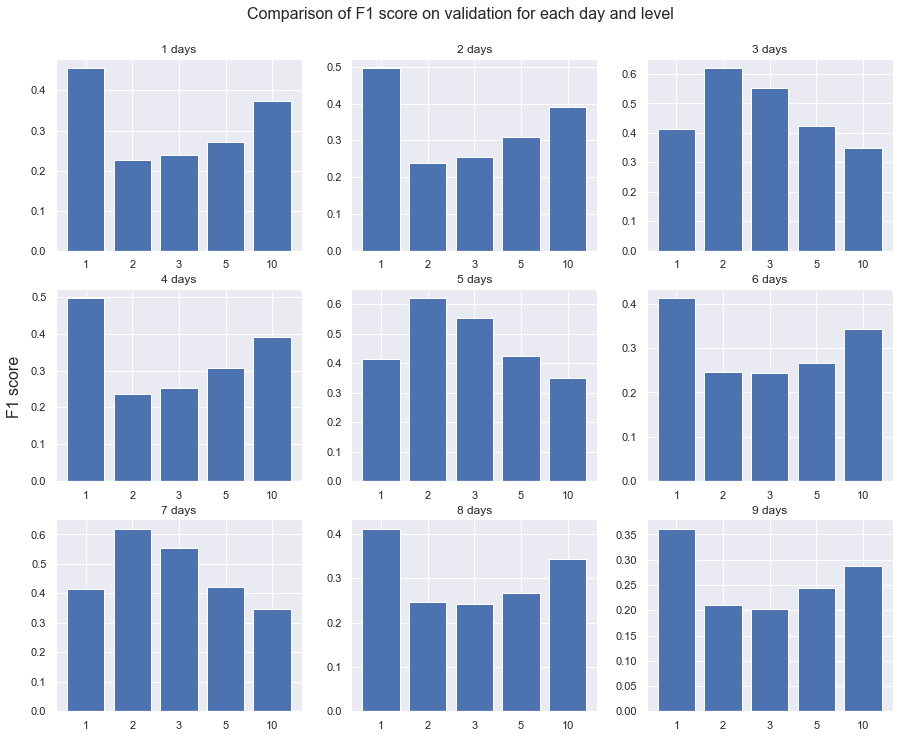

In [116]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))

c = 1
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i][j].bar(range(len(levels)),array_performance_val[:,i+j])
        axes[i][j].set_title(f'{c} days')
        axes[i][j].set_xticks(range(len(levels)), levels)
        c+=1
        
fig.supylabel('F1 score', x=0.08, fontsize=16)
fig.suptitle('Comparison of F1 score on validation for each day and level', fontsize=16,
            y=0.94);

In [124]:
for day in importances_d.keys():
    for level in range(len(levels)):
        scores = np.sort(importances_d[day][level])[::-1][:10]
        features = np.argsort(-importances_d[day][level])[:10]
        print(f'Top features for day {day} and level {level} : {features}')
    print('*'*30)

Top features for day 0 and level 0 : [127 128   1   3   5   7   9  11  17  82]
Top features for day 0 and level 1 : [ 88  86 127 128  92  90   1  94   3  83]
Top features for day 0 and level 2 : [127  88 128  86   1   3   7  83   5  82]
Top features for day 0 and level 3 : [128 127   1   3   5   7  82  83   9  19]
Top features for day 0 and level 4 : [  1 127  82  83 128   3   5   7   9  23]
******************************
Top features for day 1 and level 0 : [127 128   1   3   7   5  11   9  17  82]
Top features for day 1 and level 1 : [ 88  86 127 128  92   1   3  90  94   7]
Top features for day 1 and level 2 : [127 128  88  86   1   3   7   5  83  82]
Top features for day 1 and level 3 : [127 128   1   3   7   5  82  83  19   9]
Top features for day 1 and level 4 : [128 127   1   3  82  83   5   7  19  11]
******************************
Top features for day 2 and level 0 : [127 128   1   3  17  82  11   5   9 140]
Top features for day 2 and level 1 : [ 86  88 127 128   1  90   3  92

#### as it can be seen, the results of f1 scores for validation is pretty similar to the ones in the paper. Features are changing on the course of days and levels.